# Modelo Arima

Hecho por: Reyes Ledesma Alexis Daniel 
<br>
Carrera: Actuaria      Exp:257162

El modelo Arima es una tecnica de prevision de series de tiemporales, una de las mas utilizadas por la eficacia de sus resultados en la obtencion de futuros datos proyectados.<br>
Debido a que captura componentes autorregresivos (AR)usa las de media móvil (MA), y aborda la no estacionariedad mediante la diferenciación (I).<br><br>
Para este proyecto se usaran los datos mensuales al tiempo de cierre del valor de las acciones de Amazon (AMZN), capturadas en los ultimos 5 años (desde 01/01/2019 al 01/11/2024) (Obtenidos en https://mx.investing.com/equities/amazon-com-inc)


In [197]:
import warnings
warnings.filterwarnings('ignore')

In [198]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

In [199]:
#import data 
df = pd.read_excel("NVDA.xlsx", header=0)
df.columns = ['Fecha', 'Valores']  
df.head()

,Fecha,Valores
0,01.11.2024,205.73
1,01.10.2024,186.40
2,01.09.2024,186.33
3,01.08.2024,178.50
4,01.07.2024,186.98


## Graficamos los valores de las acciones

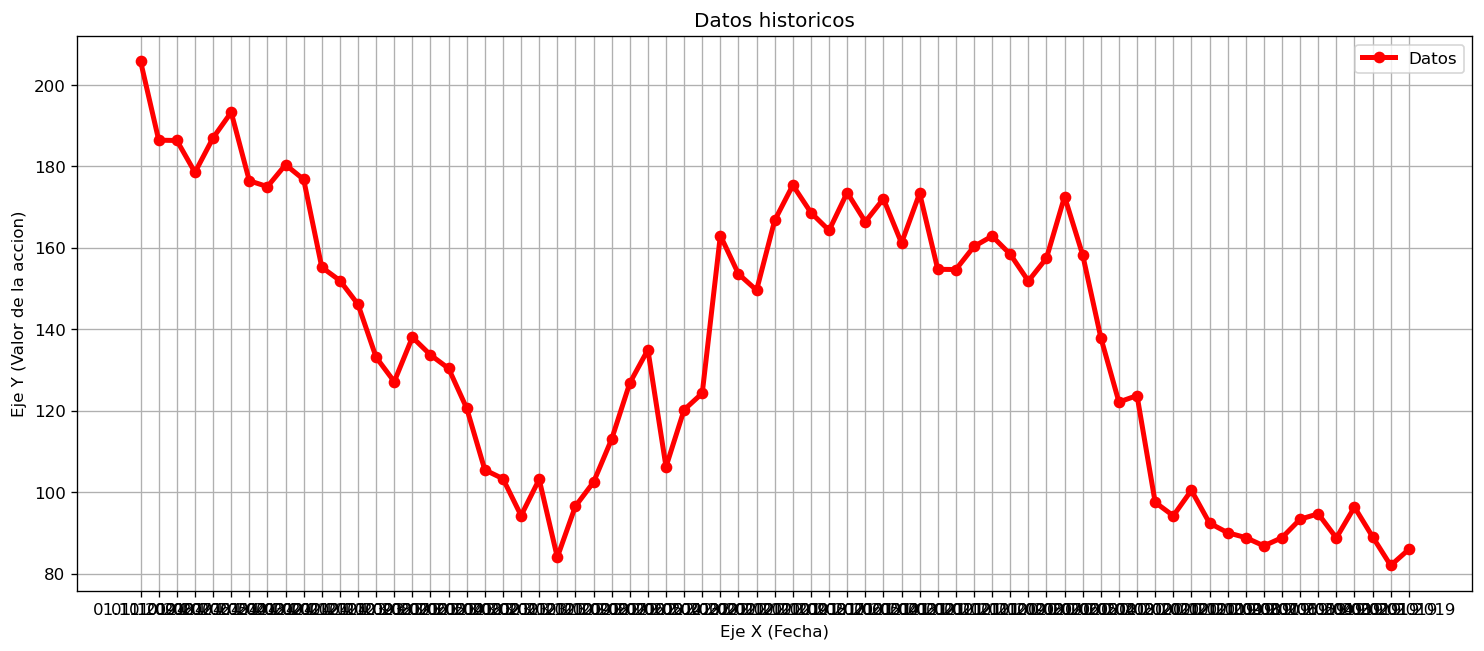

In [200]:
x = df.iloc[:, 0]  # Primera columna para el eje X
y = df.iloc[:, 1]   # Segunda columna para el eje Y

plt.figure(figsize=(15,6))
plt.plot(x, y, marker='o', label='Datos', lw= 3, color="r")
plt.title("Datos historicos")
plt.xlabel('Eje X (Fecha)')
plt.ylabel('Eje Y (Valor de la accion)')
plt.legend()
plt.grid(True)
plt.show()

#plt.plot(df ,lw=5, color="r",)
#plt.title("Datos historicos actuales", frontsize=20)

## 2. Hacemos la prueba Dickey-Fuller para saber si mis datos son estacionarios o no

In [224]:
#funcion de la prueba Dickey-Fuller 
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.Valores.dropna() ) #Usamos las variables de 'Valores' para la prueba Dickey-Fuller
print('ADF Statistic: %f' % result[0])
print('p-value: %f' %result[1])

ADF Statistic: -1.766687
p-value: 0.397122


Como el resultado del $p-valor = 0.397122$, quiere decir que el p-valor es mayor al nivel de significancia (0.05), quiere decir que la serie de tiempo no es estacionaria. <br>
Por lo tanto, debemos encontrar la orden diferencial que nos pueda servir para el modelo ARIMA.

## 3. Buscamos la diferenciacion para el valor de $d$

<br>Ahora usaremos dos diferencias para reconocer la autocorrelacion de los diferentes modelos, y a cada diferencia les haremos la prueba Dickey-Fuller, para saber cual usaremos para el modelo ARIMA.

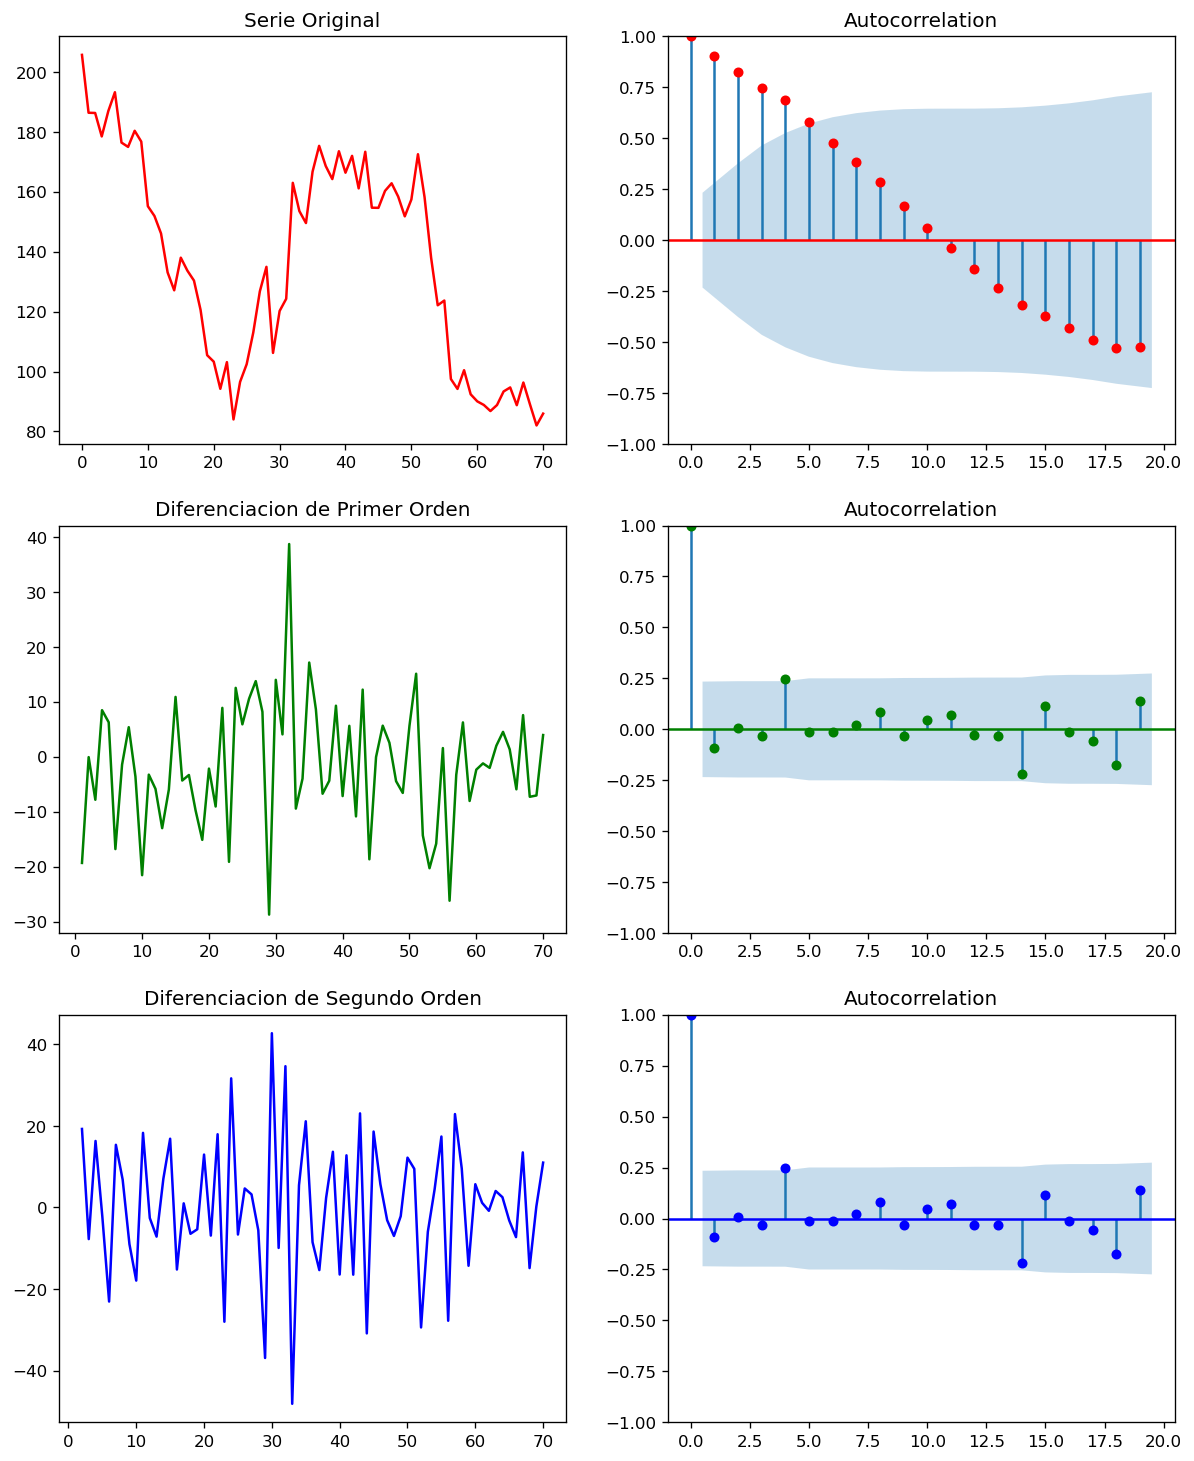

In [203]:
plt.rcParams.update({'figure.figsize':(12,15), 'figure.dpi':120})

#Serie Original
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df.Valores, color="r"); axes[0, 0].set_title('Serie Original')
plot_acf(df.Valores, ax=axes[0, 1], color="r")

#Primera diferencia
axes[1, 0].plot(df.Valores.diff(), color="g"); axes[1, 0].set_title("Diferenciacion de Primer Orden")
plot_acf(df.Valores.diff().dropna(), ax=axes[1, 1], color="g")

#Segunda diferencia
axes[2, 0].plot(df.Valores.diff().diff(), color="b"); axes[2, 0].set_title("Diferenciacion de Segundo Orden")
plot_acf(df.Valores.diff().dropna(), ax=axes[2, 1], color="b")

plt.show()

Analisando las dos diferenciaciones, podemos considerar que no existe un cambio drastico que diferencie la autocorrelacion entre los datos diferenciados.<br>Lo siguiente sera hacer la prueba Dickey-Fuller en ambas diferencias.

In [204]:
#Segunda prueba con los datos diferenciados una vez
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.Valores.diff().dropna() )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' %result[1])

ADF Statistic: -9.121383
p-value: 0.000000


In [205]:
#Tercera prueba con los datos diferenciados dos vez
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.Valores.diff().diff().dropna() )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' %result[1])

ADF Statistic: -10.154064
p-value: 0.000000


Con los resultados de la prueba Dickey-Fuller, podemos ver que en ambas diferencias el $p-valor < 0.05$ <br>
Por lo tanto, usaremos la primera diferencicion ($d = 1$).

## 4. Buscar el orden del termino AR para hallar el valor de $p$

Identificamos si el modelo necesita algun termino AR, para ello necesitaremos inspecionar el grafico de autocorrelacion parcial (PACF).<br>
Primero consideraremos el uso de la diferencia de primer orden, y buscamos el orden en termino AR como igual a tantos rezagos que cruzan el limite de significancia en la grafica PACF.

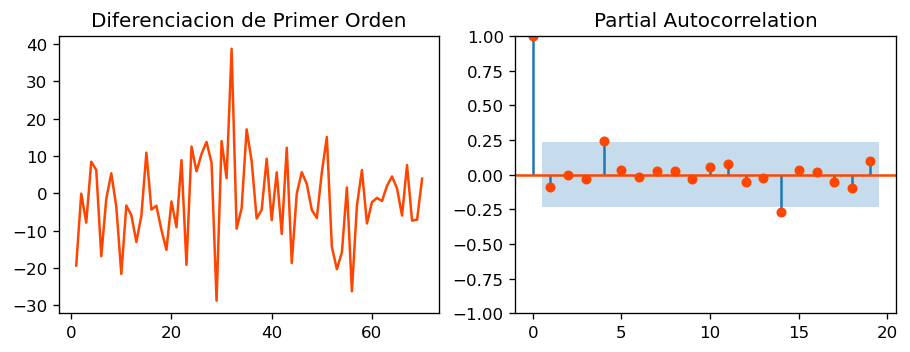

In [227]:
#PACF plot de la primera serie diferenciada
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.Valores.diff(), color="orangered"); axes[0].set_title("Diferenciacion de Primer Orden")
axes[1].set(ylim=(-1,4))
plot_pacf(df.Valores.diff().dropna(), ax=axes[1], color="orangered")
plt.show()

Podemos observar que el retraso PACF 1 es bastante significativo ya que esta muy por encima de la linea de importancia. El retardo 2 y 3 tambien resulto significativo, logrando cruzar levemente el limite de significancia (region azul). Pero para tomar una perspectiva mas conservadora fijaremos el valor de $p$ en $1$. 

## 5. Buscar el orden del termino MA para hallar el valor de $q$

Al igual que el anterior, usaremos el grafico ACF para encontrar el numero en terminos de MA, que son el error del pronostico retrasado.<br>

In [228]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

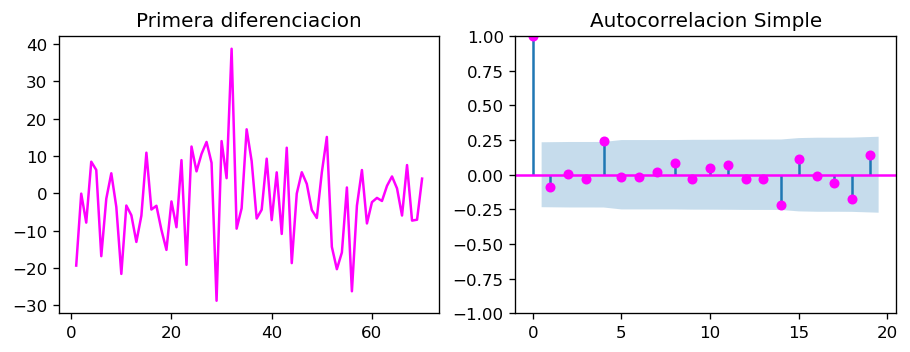

In [229]:
#Importar la data
df = pd.read_excel("NVDA.xlsx", header=0)
df.columns = ['Fecha', 'Valores']  

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.Valores.diff().dropna(), color="fuchsia"); axes[0].set_title('Primera diferenciacion')
axes[1].set(ylim=(-2,4))
plot_acf(df.Valores.diff().dropna(), ax=axes[1],color="fuchsia")
plt.title("Autocorrelacion Simple")

plt.show()

Observando los resultados de la grafica ACF, observamos que solo tiene un retraso por encima de la linea de importancio. Por lo cual fijaremos el valor de $q$ en $1$.

## 6. Construimos el modelo ARIMA

Ya obtenidos los resultados de p, q y d, podremos utilizarlo para los ajustes del modelo ARIMA.

In [231]:
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_excel("NVDA.xlsx", header=0)
df.columns = ['Fecha', 'Valores']  

# 1,1,1 ARIMA Model
model = ARIMA(df.Valores,order=(1, 1, 1)) # Cambia (p, d, q) según el modelo
result = model.fit()
print(result.summary())


                               SARIMAX Results                                
Dep. Variable:                Valores   No. Observations:                   71
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -269.929
Date:                Thu, 28 Nov 2024   AIC                            545.858
Time:                        21:13:11   BIC                            552.603
Sample:                             0   HQIC                           548.537
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8033      0.458     -1.756      0.079      -1.700       0.093
ma.L1          0.7318      0.549      1.333      0.182      -0.344       1.808
sigma2       130.8298     21.459      6.097      0.0

Los datos obtenidos de la tabla SARIMAX revela bastante informacion. Desde los coeficientes del modelo, los errores estandar, los valores de z. <br>
Tambien hay que tener en cuenta que los valores de "coef" son los pesos de los terminos respectivos.<br>
De igual forma debemos observar que si el termino $p$ en $P>|z|$ del termino ma.L1 es cercano a 0, quiere decir que esa columna de datos es muy significativo.<br>
Por ultimo si vemos que el resultado de la prueba Ljung=Box es menor a 0.05 (Como es en el caso de esta prueba ARIMA) quiere decir que en la prueba no hay ruido blanco (el modelo esta bien ajustado).

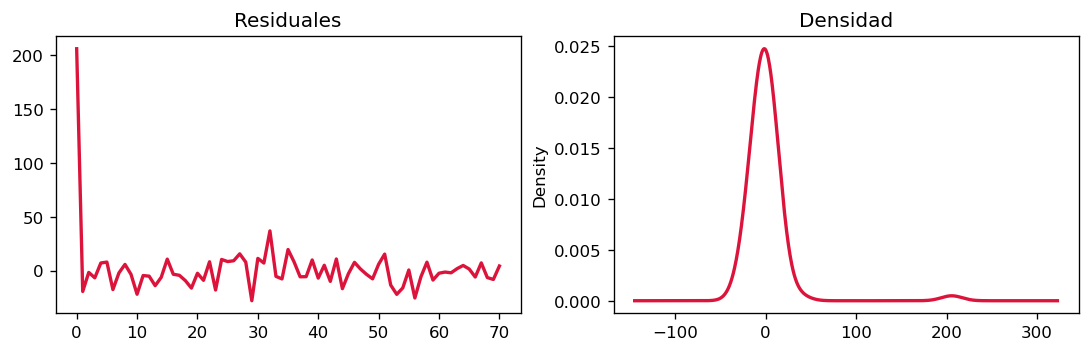

In [210]:
plt.rcParams.update({'figure.figsize':(11,3), 'figure.dpi':120})
#Plot residual errorer
residuals = result.resid
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuales", ax=ax[0], color="crimson", lw=2)
residuals.plot(kind='kde', title="Densidad", ax=ax[1], color="crimson", lw=2)
plt.show()


Checando la grafica de los errores residuales, observamos que los valores varian entre una media cercana a 0, y aunque tienen una distribucion normal, los errores estan orientados al lado isquierdo. 

## 7. Mostramos una grafica que diferencie los valores reales contra los valores ajustados

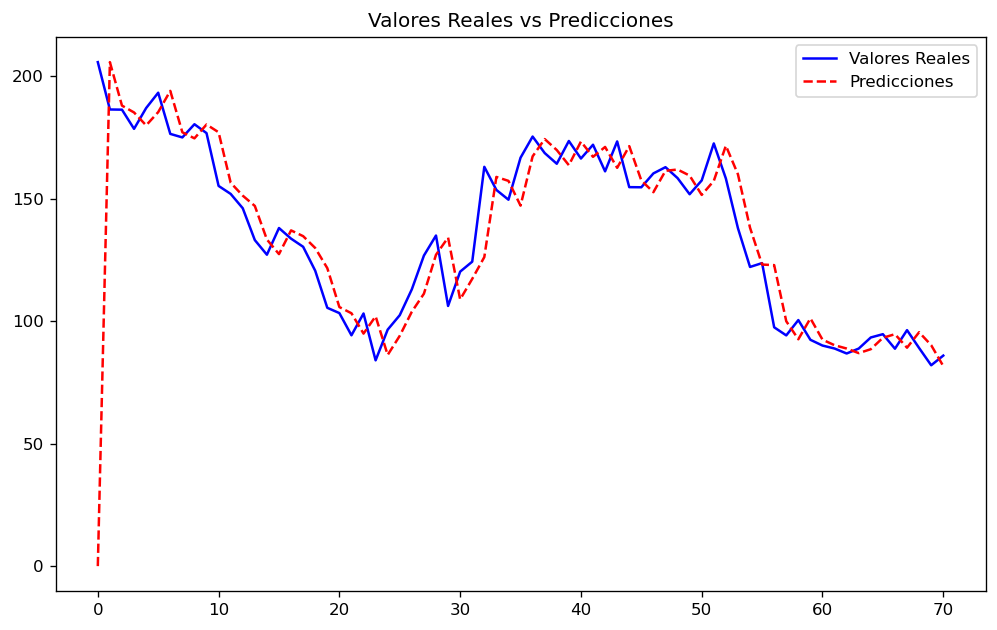

In [211]:
#Valores Actual vs Fitted
pred = result.predict(start=0, end=len(df) - 1, dynamic=False)

# Graficar los valores reales y ajustados
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Valores'], label='Valores Reales', color='blue')
plt.plot(df.index, pred, label='Predicciones', color='red', linestyle='--')
plt.title("Valores Reales vs Predicciones")
plt.legend()
plt.show()
#result.plot_predict(dynamic=False)
#plt.show()

## 8. Buscaremos el modelo ARIMA optimo manualmente usando la validacion cruzada fuera del tiempo

En la validacion fuera de tiempo, retrocede unos poco pasos en el tiempo y pronostica en el futuro tantos pasos hacia atras. Despues se compara el pronostico con los datos reales.

In [212]:
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [213]:
X = df[["Valores"]]
train, test = X[0:-15], X[-15:]

In [244]:
#Construyendo el Modelo

#model = ARIMA(train, order=(3,2,1))
model_3 = ARIMA(train, order=(1, 2, 2))
fitted = model_3.fit()

In [245]:
#Forecast

#forecast_values = fitted.forecast(steps=15)
#print(f"Valores pronosticados:  \n{forecast_values}")

forecast = fitted.get_forecast(steps=len(test), alpha=0.05) #Con 95% de confiabilidad
forecast_values = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()
print(f"Valores pronosticados:  \n{forecast_values}")

Valores pronosticados:  
56    120.278726
57    118.877758
58    115.850265
59    114.132268
60    111.360012
61    109.436527
62    106.829706
63    104.773032
64    102.273441
65    100.130436
66     97.700348
67     95.501388
68     93.116350
69     90.881120
70     88.525282
Name: predicted_mean, dtype: float64


In [246]:
#Hacemos una serie en pandas

fc_series = pd.Series(forecast_values, test.index)
lower_series = pd.Series(forecast_conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(forecast_conf_int.iloc[:, 1], index=test.index)

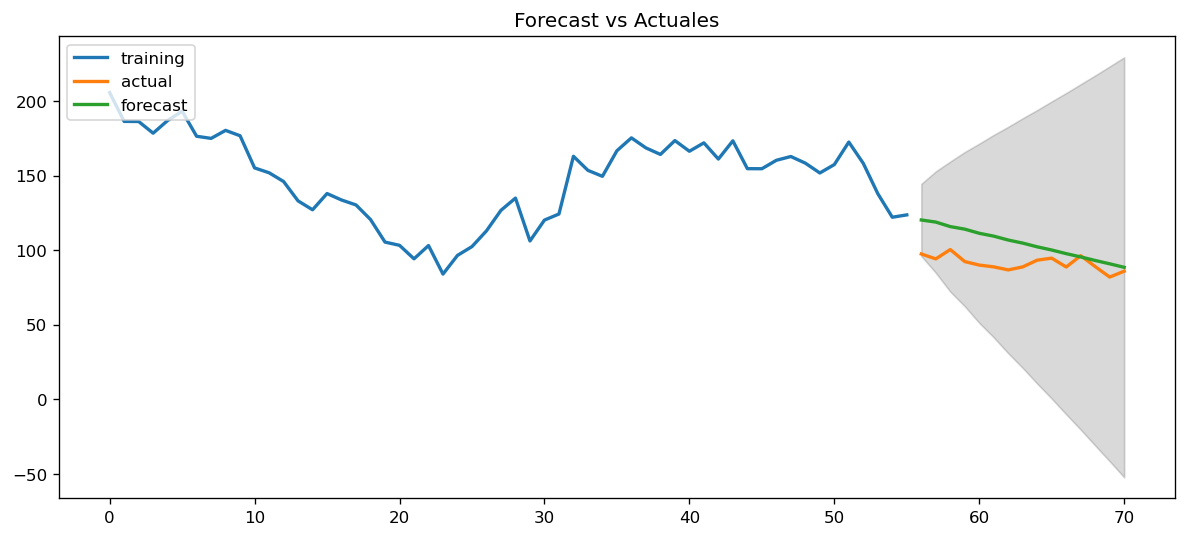

In [247]:
#Plot
plt.figure(figsize=(12,5))
plt.plot(train, label='training', lw=2)
plt.plot(test, label='actual', lw=2)
plt.plot(fc_series, label = 'forecast', lw=2)
plt.fill_between(lower_series.index, lower_series, upper_series,
                color='k', alpha = .15)
plt.title('Forecast vs Actuales')
plt.legend(loc='upper left', fontsize=10)
plt.show()

A partir del grafico, el modelo ARIMA (1,2,2), parece dar un pronostico mas preciso que con el ARIMA (1,1,1), los valores reales observados se encuentran dentro de la banda de confianza (la zina gris) del 95%.<br> Sin embargo los valores actuales y los obtenidos del forecasting no se relacionan.

## 9. Metricas de precision para el pronostico de las series de tiempo

Las metricas que calcularemos seran:
* Error de porcentaje absoluto medio (MAPE)
* Error medio (ME)
* Error absoluto medio (MAE)
* Error de porcentaje medio (MPE)
* Error cuadratico medio (RMSE)
* Autocorrelacion de error con retraso 1 (ACF1)

In [248]:
from sklearn import metrics

In [249]:
# Función de métricas corregida
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print('Resultados de la evaluación de métricas:')
    print(f'MSE es: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MSE es: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE es: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE es: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 es: {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [250]:
timeseries_evaluation_metrics_func(test, forecast_values)

Resultados de la evaluación de métricas:
MSE es: 244.45697026623066
MSE es: 13.484258821690128
RMSE es: 15.635119771406634
MAPE es: 15.9990868822962
R2 es: -9.997562647085244



## 10. Usamos la prueba de auto-Arima para  para saber cual seria los valores del ARIMA optimo

In [239]:
#Usamos el auto-ARIMA para ver si llegamos a obtener el mejor resultado
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [252]:
df = pd.read_excel("NVDA.xlsx", header=0)
df.columns = ['Fecha', 'Valores']  
df.head()

model_auto = pm.auto_arima(df.Valores, start_p=1, start_q=1,
                           test='adf',           #Usamos sdfest para encontrar la 'd' optima
                           max_p=3, max_q=3,     #Maximo de p y q
                           m=1,                  #Frecuencia de series
                           d=None,               # Determina el modelo "d"
                           seasonal=False,       # Sin estacionalidad
                           start_P=0,
                           D=0,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=544.208, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=589.250, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=567.725, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=587.278, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=546.023, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=544.085, Time=0.04 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=545.926, Time=0.09 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=542.172, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=544.007, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=542.299, Time=0.03 sec
 A

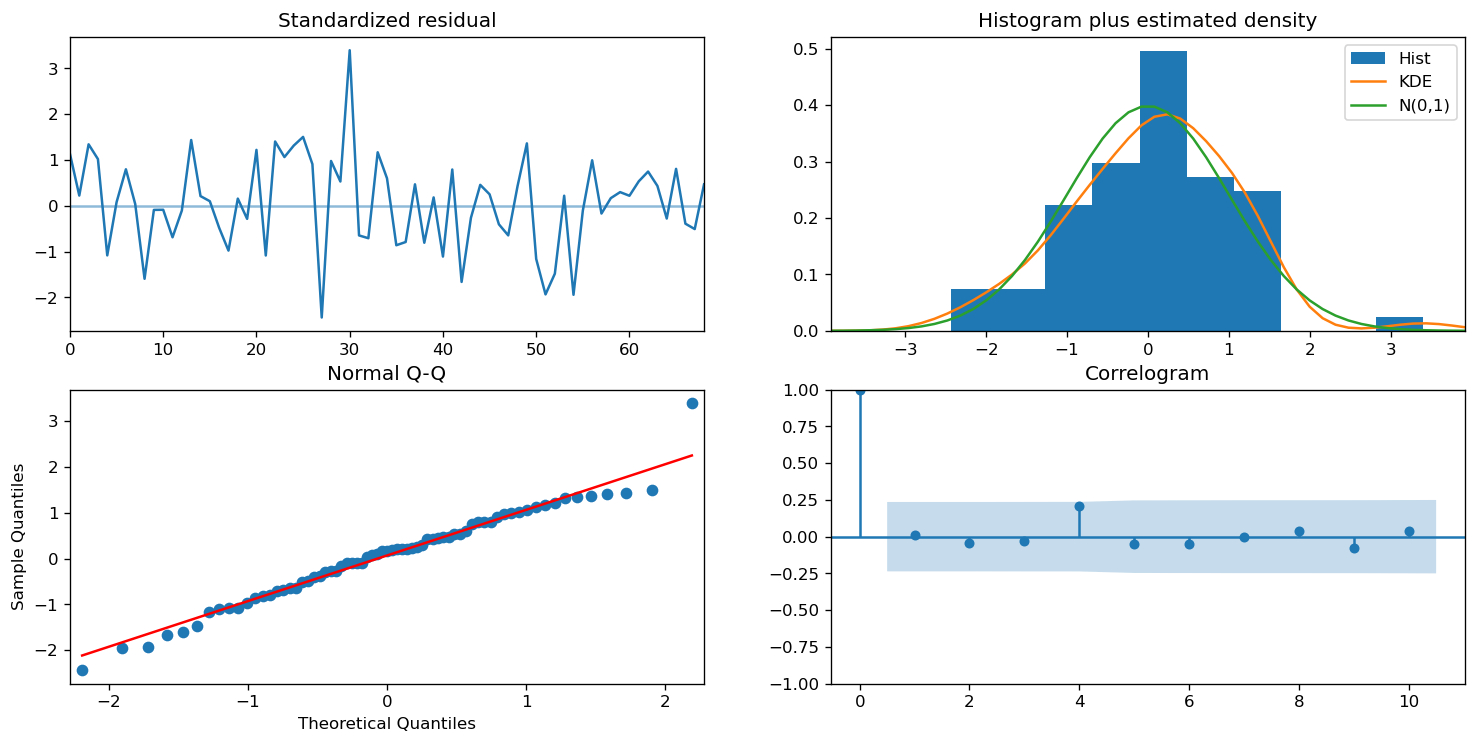

In [253]:
model_auto.plot_diagnostics(figsize=(15,7))
plt.show()

Al final el codigo auto-arima es el modelo ARIMA(0,2,2) con (0,0,0)<br>
En los datos de las graficas podemos observar que el los errores residuales fluctuan wn una media estandar de 0 con una varianza uniforme. <br><br>
En el histograma o grafico de densidad, muestra una distribucion normal y centrado. <br><br>
En el grafico normal Q-Q, nos muestra que la mayoria de los datos estan alineados con la linea roja, en este grafico si todos los puntos no estan perfectamente alineados, significa que la distribucion esta sesgada.<br><br>
Y el grafico de auto-correlograma, muestra que los errores residuales no estan autocorrelacionados. Cualquier autocorrelacion implicaria que existe algun patron en los errores residuales que no se explican en el modelo. Por lo tanto, se debera buscar mas valores en el modelo.

## 11. Mostramos la grafica usando los valoress del forecast

In [263]:
# Forecast
n_periods = 24
fc, confint = model_auto.predict(n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.Valores), len(df.Valores)+n_periods)

In [264]:
#Make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

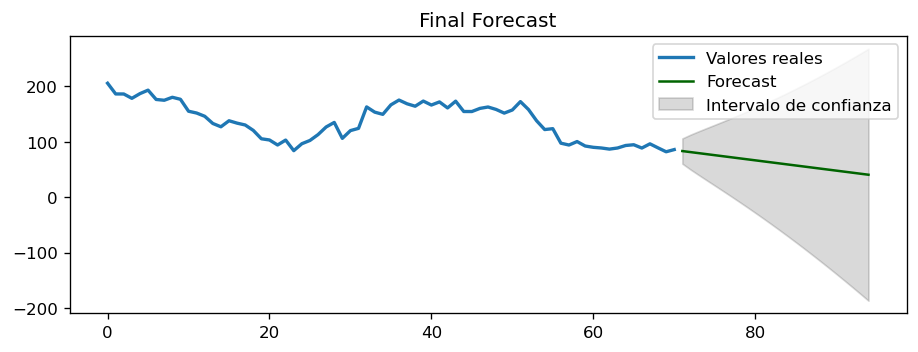

In [265]:
#Plot
plt.plot(df.Valores, lw=2, label="Valores reales")
plt.plot(fc_series, color='darkgreen', label="Forecast")
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15, label="Intervalo de confianza")

plt.title("Final Forecast")
plt.legend()
plt.show()
        

Finalmente, mostramos en esta grafica una representacion de los valores del forecast, que se encontrarian dentro del intervalo de confianza y que conectan con los valores reales.